# Linear Regression with PyTorch
In this section we'll use PyTorch's machine learning model to progressively develop a best-fit line for a given set of data points. Like most linear regression algorithms, we're seeking to minimize the error between our model and the actual data, using a <em>loss function</em> like mean-squared-error.

Let us recall the main steps we need to make our linera regression work:
0. Generate data
1. Design model (inpu, output size, forward pass)
2. Construc loss and optimizer
3. Training loop:
- forward pass: compute prediction and loss
- backward pass : gradients
- update weights


## Perform standard imports

In [2]:
import torch
import torch.nn as nn  # this is the pytorch module for neural networks

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Create noisy data for linear regression


In [3]:
X = torch.linspace(1,50,50).reshape(-1,1)
# Equivalent to
# X = torch.unsqueeze(torch.linspace(1,50,50), dim=1)

In [4]:
torch.manual_seed(71) # to obtain reproducible results
e = torch.randint(-8,9,(50,1),dtype=torch.float)
print(e.sum()) # we want the mean of the noise to be 0

tensor(0.)


In [5]:
y = 2*X + 1 + e
print(y.shape)

torch.Size([50, 1])


### Plot the results
We have to convert tensors to NumPy arrays just for plotting.

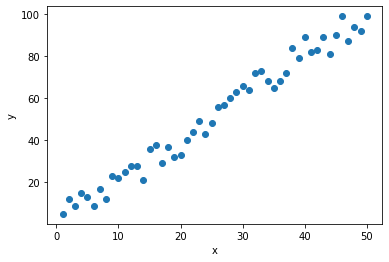

In [6]:
plt.scatter(X.numpy(), y.numpy())
plt.ylabel('y')
plt.xlabel('x');

Note that when we created tensor $X$, we did <em>not</em> pass <tt>requires_grad=True</tt>. This means that $y$ doesn't have a gradient function, and <tt>y.backward()</tt> won't work. Since PyTorch is not tracking operations, it doesn't know the relationship between $X$ and $y$.

## Simple linear model
As a quick demonstration we'll show how the built-in <tt>nn.Linear()</tt> model preselects weight and bias values at random.

In [7]:
torch.manual_seed(59)

model = nn.Linear(in_features=1, out_features=1)
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[0.1060]], requires_grad=True)
Parameter containing:
tensor([0.9638], requires_grad=True)


### EXERCISE: Plot the initial model

Without seeing any data, the model sets a random weight of 0.1060 and a bias of 0.9638.

We can use these parameters to generate the regression line

In [8]:
# YOUR CODE HERE


We can also compute the current prediction of our model for the generated data

In [9]:
# YOUR CODE HERE


And plot the current prediction

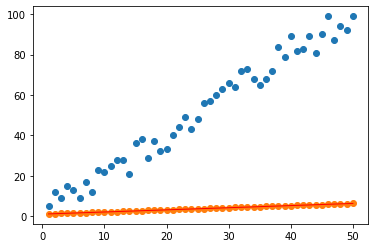

In [10]:
# YOUR CODE HERE


## Model classes
A better way to define our model is to use object classes that can store multiple model layers. 
For our simple linear regression this can be don as follows:

In [11]:
class LinearRegModel(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

<div class="alert alert-info"><strong>NOTE:</strong> The "Linear" model layer used here doesn't really refer to linear regression. Instead, it describes the type of neural network layer employed. Linear layers are also called "fully connected" or "dense" layers. Going forward our models may contain linear layers, convolutional layers, and more.</div>

When <tt>Model</tt> is instantiated, we need to pass in the size (dimensions) of the incoming and outgoing features. For our purposes we'll use (1,1).<br>As above, we can see the initial hyperparameters.

In [12]:
torch.manual_seed(59)
model = LinearRegModel(1, 1)
print(model)
print('Weight:', model.linear.weight.item())
print('Bias:  ', model.linear.bias.item())

LinearRegModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
Weight: 0.10597813129425049
Bias:   0.9637961387634277


As models become more complex, it may be better to iterate over all the model parameters:

In [13]:
for name, param in model.named_parameters():
    print(name, '\t', param.item())

linear.weight 	 0.10597813129425049
linear.bias 	 0.9637961387634277


<div class="alert alert-info"><strong>NOTE:</strong> In the above example we had our Model class accept arguments for the number of input and output features.<br>For simplicity we can hardcode them into the Model:
         
<tt><font color=black>
class Model(torch.nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.linear = Linear(1,1)<br><br>
model = Model()
</font></tt><br><br>

Alternatively we can use default arguments:

<tt><font color=black>
class Model(torch.nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self, in_dim=1, out_dim=1):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.linear = Linear(in_dim,out_dim)<br><br>
model = Model()<br>
<em>\# or</em><br>
model = Model(i,o)</font></tt>
</div>

Now let's see the result when we pass a tensor into the model.

In [14]:
x = torch.tensor([2.0])
print(model.forward(x))   # equivalent to print(model(x))

tensor([1.1758], grad_fn=<AddBackward0>)


which is confirmed with $f(x) = (0.1060)(2.0)+(0.9638) = 1.1758$

## Model Training

Now it is time for you to train your first simple model.

In order to do this you shuould procede as follow:

* Define the loss function using a criterion the Mean Squared Error (MSE), i.e. <tt>nn.MSELoss</tt>
* Set the optimization : here we want to use Stochastic Gradient descent (<tt>torch.optim.SGD()</tt>), without momentum and with learning rate (lr) equal to 0.001.  For more information, see <a href='https://pytorch.org/docs/stable/optim.html'><strong><tt>torch.optim</tt></strong></a> .
* Then train the model for 50 epochs.

Let us see how to set the loss function and the optimization


### Set the loss function
We could write our own function to apply a Mean Squared Error (MSE) that follows<br>

$\begin{split}MSE &= \frac {1} {n} \sum_{i=1}^n {(y_i - \hat y_i)}^2 \\
&= \frac {1} {n} \sum_{i=1}^n {(y_i - (wx_i + b))}^2\end{split}$<br>

Fortunately PyTorch has it built in.<br>
<em>By convention, you'll see the variable name "criterion" used, but feel free to use something like "linear_loss_func" if that's clearer.</em>

In [15]:
criterion = nn.MSELoss()

### Set the optimization
Here we'll use <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent'>Stochastic Gradient Descent</a> (SGD) with an applied <a href='https://en.wikipedia.org/wiki/Learning_rate'>learning rate</a> (lr) of 0.001. Recall that the learning rate tells the optimizer how much to adjust each parameter on the next round of calculations. Too large a step and we run the risk of overshooting the minimum, causing the algorithm to diverge. Too small and it will take a long time to converge.

For more complicated (multivariate) data, you might also consider passing optional <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum'><tt>momentum</tt></a> and <a href='https://en.wikipedia.org/wiki/Tikhonov_regularization'><tt>weight_decay</tt></a> arguments. Momentum allows the algorithm to "roll over" small bumps to avoid local minima that can cause convergence too soon. Weight decay (also called an L2 penalty) applies to biases.

For more information, see <a href='https://pytorch.org/docs/stable/optim.html'><strong><tt>torch.optim</tt></strong></a>

In [16]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# You'll sometimes see this as
# optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

### EXERCISE: 

### 1. Run a loop to train the model

Getting appropriate parameters for our model requires to repeatedely modifying the weigths of our network for multiple epochs. An <em>epoch</em> is a single pass through the entire dataset. 

We want to pick a sufficiently large number of epochs to reach a plateau close to our known parameters of $\mathrm {weight} = 2,\; \mathrm {bias} = 1$

Try to train you model remembering the steps needed for training discussed at the beginning of this notebook.

Do not forget to put the command <tt>optimizer.zero_grad()</tt> after the forward pass. This will prevent gradients to accumulate. Indeed the function `optimizer.zero_grad()` sets the gradients of all parameters to zero. While this function seems notvery relevant at first, it is a crucial pre-step before performing backpropagation. If we call the `backward` function on the loss while the parameter gradients are non-zero from the previous batch, the new gradients would actually be added to the previous ones instead of overwriting them. This is done because a parameter might occur multiple times in a computation graph, and we need to sum the gradients in this case instead of replacing them. 

Hence, remember to call `optimizer.zero_grad()` before calculating the gradients of an epoch (or of a batch).


In [17]:
# YOUR CODE HERE
# Print the following during training:
#     print(f'epoch: {i:2}  loss: {loss.item():10.8f}  weight: {model.linear.weight.item():10.8f}  \
# bias: {model.linear.bias.item():10.8f}')



epoch:  1  loss: 3057.21679688  weight: 0.10597813  bias: 0.96379614
epoch:  2  loss: 1588.53063965  weight: 3.33490014  bias: 1.06046367
epoch:  3  loss: 830.29992676  weight: 1.01483285  bias: 0.99226284
epoch:  4  loss: 438.85217285  weight: 2.68179941  bias: 1.04252183
epoch:  5  loss: 236.76144409  weight: 1.48402131  bias: 1.00766504
epoch:  6  loss: 132.42912292  weight: 2.34460592  bias: 1.03396463
epoch:  7  loss: 78.56572723  weight: 1.72622538  bias: 1.01632178
epoch:  8  loss: 50.75775909  weight: 2.17050409  bias: 1.03025162
epoch:  9  loss: 36.40123367  weight: 1.85124576  bias: 1.02149546
epoch: 10  loss: 28.98922920  weight: 2.08060074  bias: 1.02903891
epoch: 11  loss: 25.16238213  weight: 1.91576838  bias: 1.02487016
epoch: 12  loss: 23.18647385  weight: 2.03416562  bias: 1.02911627
epoch: 13  loss: 22.16612625  weight: 1.94905841  bias: 1.02731562
epoch: 14  loss: 21.63911057  weight: 2.01017213  bias: 1.02985907
epoch: 15  loss: 21.36677170  weight: 1.96622372  bias

/home/stef/anaconda3/envs/StableBaselines/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


## 2. Plot the loss values
Let's see how loss changed over time. This will allow you to choose a reasonable learning rate

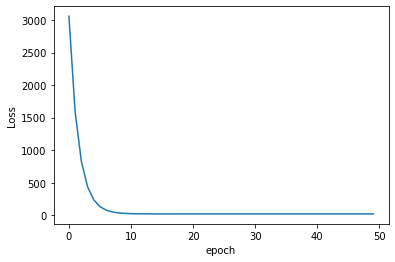

In [18]:
# YOUR CODE HERE


## 3. Plot the result
Now we'll derive <tt>y1</tt> from the new model to plot the most recent best-fit line.

Current weight: 1.98381913, Current bias: 1.05575156



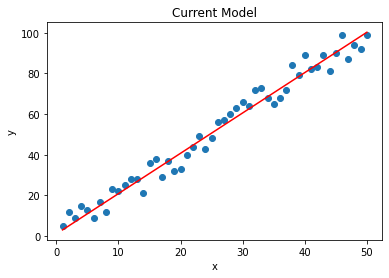

In [19]:
# YOUR CODE HERE
